# Задание

1) Реализовать стандартную функцию свертки​.
2) Реализовать функцию свертки через im2col.
3) Реализовать Depthwise-separable свертку.

* Специфицировать размер, количество фильтров, входной tensor, stride, padding...
* Придумать тесты для проверки работоспособности вариантов свёртки.​

# Настройки/Импорты

In [1]:
import numpy as np # для работы с массивами
import torch # для работы с тензорами
import torch.nn.functional as F # для функций с тензорами
import torchvision.io as tv # для работы с изображениями
import keras # для проверки Depthwise-separable свёртки
from tqdm import tqdm # для отслеживания прогресса
from matplotlib import pyplot as plt # для построения графиков/вывода изображений

# Вспомогательные функции

In [2]:
def show_image(image, figsize: tuple, gray: bool=False) -> None:
    """
    Функция для вывода изображений.\n
    Parameters:
        * image: изображение, что нужно вывести
        * figsize: размер выводимой картинки
        * gray: флаг, является ли изображение одноканальным (чёрно-белым)\n
    Returns:
        * None
    """
    cmap = "gray" if gray else "viridis" # выбор цветовой схемы, (стандартная — "viridis", но если передан ключ gray — "gray")

    plt.figure(figsize=figsize) # размер фигуры
    plt.imshow(image, cmap) # вывод изображения
    plt.show() # показ фигуры

# 1) Реализация стандартной свёртки.

<img src="./images/conv_simple.png" alt="Simple convolution"/>

Функция свёртки:
$$
\mathbf{Out}[id_{conv}][x][y] = \sum_{i=0}^{H_{conv}-1}\sum_{j=0}^{W_{conv}-1}\sum_{c=0}^{Channels-1}\mathbf{Input}[c][Sx+i][Sy+j] * \mathbf{W}[id_{conv}][c][i][j] + \mathbf{b}[id_{conv}]
$$
Где:
* Input — входная матрица размерности (Channels, Height, Width) ~ (Channels, $H_{in}$, $W_{in}$)
* W — матрица весов свёрточного слоя размерности (Num_filters, Channels, $H_{conv}$, $W_{conv}$)
* b — смещения (bias) для вильтров свёртки (одно число на фильтр) размерности (Num_filters)
* Out — выходная матрица (Num_filters, $H_{out}$, $W_{out}$), где $H_{out}$, $W_{out}$ зависят от параметров свёртки
* $id_{conv}$  — номер рассматриваемой свёртки (фильтра свёртки), изменяется от 0 до Num_filters-1
* x — координата **нового** пикселя по вертикали ~ номер строки (в изначальном изображении — Height ~ $H_{in}$)
* y — координата **нового** пикселя по горизонтали ~ номер столбца (в изначальном изображении — Width ~ $W_{in}$)
* $H_{conv}$ — размер ядра свёртки по вертикали (итерируемся с помощью *i*)
* $W_{conv}$ — размер ядра свёртки по горизонтали (итерируемся с помощью *j*)
* Channels — число каналов (фильтров) у входного тензора (итерируемся с помощью *c*)
* S — значение параметра "Stride", отвечающее за размер шага по изображению (смещение по изображению)

In [3]:
def conv_simple(Input, W, b, stride: int=1, padding: int=0) -> torch.Tensor:
    """
    Функция простой свёртки.\n
    Parameters:
        * Input: входной массив размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)
        * W: веса для ядер свёртки
        * b: bias, смещение для фильтра свёртки
        * stride: размер шага по осям (одинаков как для оси OX, так и для OY)
        * padding: значение количества добавляемх "размерностей" по краям входного массива, не включая размерность, отвечающую за каналы (одинаков как для оси OX, так и для OY)\n
    Returns:
        * torch.Tensor: результат применения свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы
    Num_filters, Channels, H_conv, W_conv = W.shape # берём значения Num_filters, Channels, H_conv, W_conv из матрицы весов свёртки (Channels должен совпадать с аналогичной размерность из Input)

    Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

    H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
    W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора
    Out = torch.zeros(size=(Num_filters, H_out, W_out), dtype=torch.float32) # заготовка под выходной тензор, заполненная нулями
    
    # print(f"Input_padded shape: {Input_padded.shape}")
    # print(f"Out shape: {Out.shape}")

    for id_filter in range(Num_filters): # идём по числу фильтров в одной свёртке (range вернёт список чисел от 0 до Num_filters-1 включительно)
        for x in range(H_out): # идём по пикселям высоты выходного тензора
            for y in range(W_out): # идём по пикселям ширины выходного тензора
#=========================== вариант через медленное сложение всех элементов ========================
                # for i in range(H_conv): # идём по высоте фильтра (ядра) свёртки
                #     for j in range(W_conv): # идём по ширине фильтра (ядра) свёртки
                #         for c in range(Channels): # идём по каналам входного изображения
                #             Out[id_filter][x][y] += Input_padded[c][stride*x + i][stride*y + j] * W [id_filter][c][i][j]
#--------------------------- вариант через быстрое перемножение тензоров ----------------------------
                H_from, H_to = stride*x, stride*x+H_conv # с какого пикселя по какой смотреть на входном изображении по вертикали
                W_from, W_to = stride*y, stride*y+W_conv # с какого пикселя по какой смотреть на входном изображении по горизонтали
                Out[id_filter][x][y] = torch.sum(Input_padded[:, H_from:H_to, W_from:W_to] * W[id_filter]) # перемножаем матрицы Input_padded в нужной области и W поэлементно (у них должна быть одинаковая размерность) и складываем все элементы получившейся матрицы
#====================================================================================================
                Out[id_filter][x][y] += b[id_filter] # добавляем смещение фильтра (bias)
                            
    return Out # возвращаем полученный массив

# 2) Реализация свёртки через im2col.

<img src="./images/conv_im2col.png" alt="im2col convolution"/>

In [4]:
def conv_im2col(Input, W, b, stride: int=1, padding: int=0, conv_back: bool=True) -> torch.Tensor:
    """
    Функция свёртки через im2col.\n
    Parameters:
        * Input: входной массив размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)
        * W: веса для ядер свёртки
        * b: bias, смещение для фильтра свёртки
        * stride: размер шага по осям (одинаков как для оси OX, так и для OY)
        * padding: значение количества добавляемх "размерностей" по краям входного массива, не включая размерность, отвечающую за каналы (одинаков как для оси OX, так и для OY)
        * conv_back: флаг, нужно ли делать обратную конвертацию из 2d тензора (Num_filters, H_out*W_out) в 3d тензор (Num_filters, H_out, W_out)\n
    Returns:
        * torch.Tensor: результат применения свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы
    Num_filters, Channels, H_conv, W_conv = W.shape # берём значения Num_filters, Channels, H_conv, W_conv из матрицы весов свёртки (Channels должен совпадать с аналогичной размерность из Input)

    Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

    H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
    W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора

    # уменьшаем размерность матриц до 2d
    Input_2d = torch.zeros(size=(H_conv*W_conv*Channels, H_out*W_out), dtype=torch.float32) # входной массив, преобразованный из 3d в 2d размерности (H_conv*W_conv*Channels, H_out*W_out)
    for id_patch in range(H_out*W_out): # идём по столбцам 2d тензора входа (Patch_ам)
        x = id_patch % W_out # номер рассматриваемой строки
        H_from, H_to = stride*x, stride*x+H_conv # с какого пикселя по какой смотреть на входном изображении по вертикали
        y = id_patch // W_out # номер рассматриваемого столбца
        W_from, W_to = stride*y, stride*y+W_conv # с какого пикселя по какой смотреть на входном изображении по горизонтали
        Input_2d[:, id_patch] = Input_padded[:, H_from:H_to, W_from:W_to].flatten() # записываем значение в колонку (flatten "расправляет" все элементы массива в вектор)
    
    W_2d = torch.zeros(size=(Num_filters, H_conv*W_conv*Channels), dtype=torch.float32) # фильтры, объединённые в двумерный тензор (из 3d в 2d) размерности (Num_filters, H_conv*W_conv*Channels)
    for id_filter in range(Num_filters): # идём по строкам 2d тензора весов ядер (индексам фильтров в свёрточном слое)
        W_2d[id_filter] = W[id_filter].flatten() # записываем значение в строку (flatten "расправляет" все элементы массива в вектор)

    Out = W_2d @ Input_2d # перемножаем матрицы строку на столбец (@ — аналог torch.matmul)
    for id_filter in range(Num_filters): # идём по строкам выходного тензора
        Out[id_filter] += b[id_filter] # добавляем смещение фильтра (bias)

    if conv_back: # если стоит флаг обратной конвертации
        Out = Out.reshape(Num_filters, H_out, W_out) # приводим обратно к 3d тензору размерности (Num_filters, H_out, W_out)
        Out = Out.transpose(1, 2) # транспонируем оси 1 и 2, так как тензор после reshape получается повёрнутым (0 ~ Num_filters ~ Channels не меняются, а Height и Width транспонируются)
    return Out # возвращаем полученный массив

# 3) Реализация Depthwise-separable свёртки.

<img src="./images/conv_depthwise_1.png" alt="Depthwise-separable convolution"/>

<img src="./images/conv_depthwise_2.png" alt="Depthwise-separable convolution"/>

In [5]:
def conv_depthwise_separable(Input, W_depthwise, W_pointwise, b_pointwise, stride: int=1, padding: int=0) -> torch.Tensor:
    """
    Функция Depthwise-separable свёртки.\n
    Parameters:
        * Input: входной массив размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)
        * W_depthwise: веса для ядер Depth-wise свёртки
        * W_pointwise: веса для ядер Point-wise свёртки
        * b_pointwise: bias, смещение для фильтра свёртки (добавляется после Point-wise свёртки)
        * stride: размер шага по осям (одинаков как для оси OX, так и для OY)
        * padding: значение количества добавляемх "размерностей" по краям входного массива, не включая размерность, отвечающую за каналы (одинаков как для оси OX, так и для OY)\n
    Returns:
        * torch.Tensor: результат применения свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения (Channels, Height, Width) из входной матрицы
    Channels, H_conv, W_conv = W_depthwise.shape # берём значения (Channels, H_conv, W_conv) из матрицы весов Depth-wise свёртки (Channels должен совпадать с аналогичной размерность из Input)
    Num_filters, Channels, _, _ = W_pointwise.shape # берём значения (Num_filters, Channels, 1, 1) из матрицы весов Point-wise свёртки (Channels должен совпадать с аналогичной размерность из Input)

    Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

    H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
    W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора

    # Depth-wise convolution
    Out_depthwise = torch.zeros(size=(Channels, H_out, W_out), dtype=torch.float32) # заготовка под выходной тензор с Depthwise шага, заполненная нулями
    for id_channel in range(Channels): # идём по каналам
        for x in range(H_out): # идём по пикселям высоты выходного тензора
            for y in range(W_out): # идём по пикселям ширины выходного тензора
                H_from, H_to = stride*x, stride*x+H_conv # с какого пикселя по какой смотреть на входном изображении по вертикали
                W_from, W_to = stride*y, stride*y+W_conv # с какого пикселя по какой смотреть на входном изображении по горизонтали
                Out_depthwise[id_channel][x][y] = torch.sum(Input_padded[id_channel, H_from:H_to, W_from:W_to] * W_depthwise[id_channel]) # перемножаем матрицы Input_padded в нужной области и W_depthwise поэлементно (у них должна быть одинаковая размерность) и складываем все элементы получившейся матрицы
    
    # Point-wise convolution
    Out_pointwise = torch.zeros(size=(Num_filters, H_out, W_out), dtype=torch.float32) # заготовка под выходной тензор с Pointwise шага, заполненная нулями
    for id_filter in range(Num_filters): # идём по числу фильтров в одной свёртке (range вернёт список чисел от 0 до Num_filters-1 включительно)
        Out_pointwise[id_filter] = torch.sum(W_pointwise[id_filter] * Out_depthwise, dim=0) # умножаем свёртку с ядром 1x1, отвечающую за фильтр id_filter на пришедший массив с шага Depthwise (делаем так по числу необходимых фильтров), а затем суммируем получившиеся значения на каналах
        # каналы (Channels) тензора с шага Depthwise свёртки умножаются на соответствующие им коэффициенты из W_pointwise, таким образом каждый канал ПОЛНОСТЬЮ умножается на определённое число, после чего все каналы просуммируются (останется тензор размерности (H_out, W_out))
        # dim=0 — суммирование по Channels (чтобы потом эта размерность занулилась и заменилась на число фильтров — Num_filters)
        Out_pointwise[id_filter] += b_pointwise[id_filter] # добавляем смещение фильтра (bias)
    
    return Out_pointwise # возвращаем полученный массив

# Тестирование

Берём произвольное изображение (можно даже сгенерировать случайную матрицу) в формате torch.Tensor.

In [6]:
Input = tv.read_image('./data/bird_25x25.png') # считываем изображение; в Torch изображения идут сразу в формате RGB, но в виде (Channels, Height, Width)
Input.shape # изначальная размерность изображения

torch.Size([3, 25, 25])

Пример визуализации изображения.

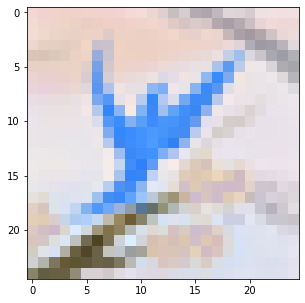

In [7]:
Input_show = Input.permute((1, 2, 0)) # приводим к формату, воспринимаемому в matplotlib, то есть меняем местами размерности: (Channels, Height, Width) => (Height, Width, Channels)
Input_show.shape # размерность для matplotlib
show_image(image=Input_show, figsize=(5, 5)) # вывод изображения

Конвертируем изображение в float32.

In [8]:
Input = Input.to(torch.float32) # переводим изначальный tensor из int8 в float32
print(Input)

tensor([[[243., 241., 240.,  ..., 241., 241., 241.],
         [242., 239., 238.,  ..., 239., 237., 237.],
         [241., 240., 237.,  ..., 209., 233., 235.],
         ...,
         [207., 224., 215.,  ..., 221., 222., 228.],
         [207., 179., 126.,  ..., 218., 221., 227.],
         [136.,  99., 103.,  ..., 220., 222., 228.]],

        [[215., 210., 211.,  ..., 225., 224., 225.],
         [219., 213., 212.,  ..., 218., 215., 216.],
         [221., 216., 212.,  ..., 194., 215., 220.],
         ...,
         [205., 227., 225.,  ..., 226., 226., 229.],
         [208., 179., 119.,  ..., 223., 223., 225.],
         [132.,  93.,  96.,  ..., 224., 224., 227.]],

        [[212., 206., 203.,  ..., 226., 226., 227.],
         [210., 205., 201.,  ..., 216., 215., 215.],
         [210., 205., 201.,  ..., 195., 214., 217.],
         ...,
         [196., 232., 243.,  ..., 239., 239., 240.],
         [212., 174.,  96.,  ..., 238., 238., 236.],
         [108.,  67.,  67.,  ..., 238., 239., 238.]]]

Функция для проверки работоспособности свёрток при различных параметрах (применится для стандартной свёртки и im2col):

In [9]:
def test_conv(func, Input) -> None:
    """
    Функция для тестирования работы свёрток. Сравнивает с реализацией свёрточного слоя на PyTorch при различных параметрах.\n
    Parameters:
        * func: функция свёртки, что нужно протестировать
        * Input: входной массив, на котором будет проводиться тестирование (в формате float32) размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)\n 
    Returns:
        * None: выдаст Exception в случае, если есть несовпадение ответов у проверяемой и контрольной функции свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы

    for Num_filters in tqdm([1, 2]): # рассматриваем возможное число фильтров
        for kernel_size in [1, 2, 3, 5, 7]: # рассматриваем возможные размеры ядер

            W = torch.randint(low=0, high=10, size=(Num_filters, Channels, kernel_size, kernel_size), dtype=torch.float32) # случайно генерируем веса для ядер свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
            # размерность W: (число ядер(фильтров) на слое свёртки, Channels — число входных каналов, высота ядра свёртки H_conv, ширина ядра свёртки W_conv)
            b = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias по аналогии
            # размерность b: (число ядер(фильтров) на слое свёртки)

            for stride in [1, 2, 5]: # рассматриваем варианты параметра stride
                for padding in [0, 1, 2]: # рассматриваем варианты параметра padding
                    # написанная функция
                    res_func = func(Input, W, b, stride, padding) # считаем результат проверяемой свёртки
                    
                    # реализация свёртки на PyTorch
                    conv_torch = torch.nn.Conv2d(in_channels=Channels, out_channels=Num_filters, kernel_size=kernel_size, stride=stride, padding=padding) # слой свёртки из PyTorch
                    conv_torch.weight.data = W # меняем веса ядер свёртки на тестируемые (со случайных, заданных при создании Conv2d)
                    conv_torch.bias.data = b # меняем bias ядер свёртки на тестируемые (со случайных, заданных при создании Conv2d)
                    
                    res_torch = conv_torch(Input) # считаем результат контрольной свёртки
                    

                    if not torch.equal(res_func, res_torch): # сравниваем, что все значения в тензорах одинаковые
                        raise Exception(f"Результат свёрток не совпал при параметрах: Num_filters={Num_filters}, kernel_size={kernel_size}, stride={stride}, padding={padding}") # если есть несовпадения — выкидываем исключение
    print("Все тесты прошли успешно!")

## Вариант 1:

In [10]:
test_conv(conv_simple, Input) # запускаем тестирование функции простой свёртки

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.36s/it]

Все тесты прошли успешно!


## Вариант 2:

In [11]:
test_conv(conv_im2col, Input) # запускаем тестирование функции свёртки через im2col

100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

Все тесты прошли успешно!


## Вариант 3:

Сравним работу Depthwise-separable свёртки с аналогичной реализацией на PyTorch и Keras.

In [12]:
class SeparableConv2d(torch.nn.Module):
    """
    Класс, реализующий Depthwise-separable свёртку на PyTorch.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding): # конструктор объекта класса
        super(SeparableConv2d, self).__init__() # для правильной инициализации базового класса torch.nn.Module
        self.depthwise = torch.nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False)
        # свёртка Depthwise шага, веса имеют размерность (Channels, 1, H_conv, W_conv)
        # выход слоя размерности (Channels, H_out, W_out), где H_out и W_out считаются по особой формуле
        # stride — размер шага по входному массиву, padding — размер добавляемых отступов для осей Height и Width входного массива
        # groups=in_channels означает, что каждому входному каналу будет соответствовать только один свёрточный слой!
        # bias=False — данный слой не имеет смещения

        self.pointwise = torch.nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1), stride=1, padding=0, groups=1, bias=True)
        # свёртка Pointwise шага, веса имеют размерность (Num_filters, Channels, 1, 1)
        # выход слоя размерности (Num_filters, H_out, W_out), где H_out и W_out считаются по особой формуле
        # stride — размер шага по входному массиву (1 — идём без пропусков), padding — размер добавляемых отступов для осей Height и Width входного массива (0 — не добавляется)
        # groups=1 означает, что каждому входному канал будет обрабатываться всеми фильтрами (ядрами) свёртки
        # bias=True — данный слой имеет смещение

    def forward(self, x): # функция, вызываемая оператором () у объекта класса
        out = self.depthwise(x) # Depthwise шаг
        out = self.pointwise(out) # Pointwise шаг
        return out

In [13]:
def test_depthwise_conv(Input) -> None:
    """
    Функция для тестирования работы Depthwise-separable свёртки. Сравнивает с аналогичной реализацией свёрточного слоя на PyTorch и Keras при различных параметрах.\n
    Parameters:
        * Input: входной массив, на котором будет проводиться тестирование (в формате float32) размерности (Channels, Height, Width) ~ (Channels, H_in, W_in)\n 
    Returns:
        * None: выдаст Exception в случае, если есть несовпадение ответов у проверяемой и контрольной функции свёртки
    """
    Channels, H_in, W_in = Input.shape # берём значения Channels, Height, Width из входной матрицы

    for Num_filters in tqdm([1, 2]): # рассматриваем возможное число фильтров
        for kernel_size in [1, 2, 3, 5, 7]: # рассматриваем возможные размеры ядер
            H_conv, W_conv = kernel_size, kernel_size # размер ядра (фильтра) свёртки

            W_depthwise = torch.randint(low=0, high=10, size=(Channels, H_conv, W_conv), dtype=torch.float32) # случайно генерируем веса для ядер Depthwise свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
            # размерность W_depthwise: (Channels — число входных каналов, высота ядра свёртки H_conv, ширина ядра свёртки W_conv)
            W_pointwise = torch.randint(low=0, high=10, size=(Num_filters, Channels, 1, 1), dtype=torch.float32) # случайно генерируем веса для ядер Pointwise свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
            # размерность W_pointwise: (число ядер(фильтров) на слое свёртки, Channels — число входных каналов, 1 — высота ядра, 1 — ширина ядра)
            b_pointwise = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias, применяемый после Pointwise свёртки
            # размерность b_pointwise: (число ядер(фильтров) на слое свёртки)

            W_depthwise_torch = W_depthwise.reshape(Channels, 1, H_conv, W_conv) # конвертируем веса Depthwise свёртки для понимания PyTorch моделью, добавляя промежуточную размерность (чтобы в PyTorch каждому каналу соответствовала одна свёртка)
            W_depthwise_keras = W_depthwise_torch.permute(2, 3, 0, 1) # конвертируем веса Depthwise свёртки для понимания Keras моделью (ПРАВИЛЬНО меняем размерности весов PyTorch местами)

            W_pointwise_torch = W_pointwise # в PyTorch веса для Pointwise свёртки не меняются
            W_pointwise_keras = W_pointwise.permute(3, 2, 1, 0) # конвертируем веса Pointwise свёртки для понимания Keras моделью (полностью поворачиваем размерности)

            b_pointwise_torch = b_pointwise # смещение не меняется
            b_pointwise_keras = b_pointwise # смещение не меняется


            for stride in [1, 2, 5]: # рассматриваем варианты параметра stride
                for padding in [0, 1, 2]: # рассматриваем варианты параметра padding
                    # написанная функция
                    res_func = conv_depthwise_separable(Input, W_depthwise, W_pointwise, b_pointwise, stride, padding) # считаем результат проверяемой свёртки

                    # реализация свёртки на PyTorch
                    conv_torch = SeparableConv2d(in_channels=Channels, out_channels=Num_filters, kernel_size=(H_conv, W_conv), stride=stride, padding=padding) # Depthwise-separable свёртка на PyTorch
                    conv_torch.depthwise.weight.data = W_depthwise_torch # устанавливаем веса для Depthwise свёртки
                    conv_torch.pointwise.weight.data = W_pointwise_torch # устанавливаем веса для Pointwise свёртки
                    conv_torch.pointwise.bias.data = b_pointwise_torch # устанавливаем смещение для Pointwise свёртки
                    
                    res_torch = conv_torch(Input) # считаем результат свёртки на PyTorch
                    if not torch.equal(res_func, res_torch): # сравниваем, что все значения в тензорах одинаковые
                        raise Exception(f"Результат свёртки не совпал с PyTorch при параметрах: Num_filters={Num_filters}, kernel_size={kernel_size}, stride={stride}, padding={padding}") # если есть несовпадения — выкидываем исключение

                    # реализация свёртки на Keras
                    Input_padded = keras.layers.ZeroPadding2D(padding=(padding, padding), data_format='channels_first')(np.array([Input])) # добавляем padding для массива (теперь он станет не torch.tensor, а np.array) на оси, отвечающие за Height и Width, а также с помощью дополнительных скобок "[Input]" имитируем batch из одного элемента, необходимый для работы Keras
                    conv_keras = keras.layers.SeparableConv2D(filters=Num_filters, kernel_size=(H_conv, W_conv), strides=stride, padding="valid", activation=None, data_format='channels_first') # Depthwise-separable свёртка на Лукфы
                    _ = conv_keras(Input_padded) # делаем фиктивный запуск для инициализации весов свёртки в keras 
                    conv_keras.set_weights([W_depthwise_keras, W_pointwise_keras, b_pointwise_keras]) # заменяем случайно инициализированные веса на те, что использовались до этого

                    res_keras = conv_keras(Input_padded) # считаем результат свёртки на Keras
                    if not np.all(res_func == res_keras): # сравниваем, что все значения в torch.Tensor и np.array одинаковые (через np.all, так как он игнорируем привязку градиентов и различие типов torch.Tensor и np.array)
                        raise Exception(f"Результат свёртки не совпал с Keras при параметрах: Num_filters={Num_filters}, kernel_size={kernel_size}, stride={stride}, padding={padding}") # если есть несовпадения — выкидываем исключение
    print("Все тесты прошли успешно!")

In [14]:
test_depthwise_conv(Input) # запускаем тестирование функции Depthwise-separable свёртки

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:09<00:00,  4.57s/it]

Все тесты прошли успешно!


# Пример работы с произвольным тензором

In [15]:
stride = 2 # размер шага по осям (одинаков как для оси OX, так и для OY)
padding = 1 # размер добавляемых отступов для осей Height и Width входного массива

Channels, H_in, W_in = 3, 5, 5 # число каналов, высота и ширина у входного тензора
H_conv, W_conv = 4, 4 # размеры ядер (фильтров) свёрток
Num_filters = 6 # число каналов (фильтров) на выходе

Input = torch.randint(low=0, high=9, size=(Channels, H_in, W_in), dtype=torch.float32) # случайно генерируем тензор
Input_padded = F.pad(input=Input, pad=(padding, padding, padding, padding, 0, 0), mode='constant', value=0) # добавляем padding из value на входной массив (0,0 — отвечают за добавляемую размерность в Channels (до и после исходных данных), остальные по аналогии за Width и Height)

H_out = int((H_in + 2*padding - (H_conv-1) - 1) / stride + 1) # Height выходного тензора
W_out = int((W_in + 2*padding - (W_conv-1) - 1) / stride + 1) # Width выходного тензора
print(f"Ожидаемая размерность выходного тензора: (Num_filters: {Num_filters}, Height: {H_out}, Width:{W_out}).")

W = torch.randint(low=0, high=10, size=(Num_filters, Channels, H_conv, W_conv), dtype=torch.float32) # случайно генерируем веса для ядер свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
b = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias по аналогии
# W_depthwise = torch.randint(low=0, high=10, size=(Channels, H_conv, W_conv), dtype=torch.float32) # случайно генерируем веса для ядер Depthwise свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
# W_pointwise = torch.randint(low=0, high=10, size=(Num_filters, Channels, 1, 1), dtype=torch.float32) # случайно генерируем веса для ядер Pointwise свёртки (int от 0 до 10 — чтобы решение всегда было точным с последующей конвертацией в float32)
# b_pointwise = torch.randint(low=0, high=10, size=(Num_filters,), dtype=torch.float32) # bias, применяемый после Pointwise свёртки

Ожидаемая размерность выходного тензора: (Num_filters: 6, Height: 2, Width:2).


In [16]:
Input_padded # вид тензора после паддинга

tensor([[[0., 0., 0., 0., 0., 0., 0.],
         [0., 5., 3., 7., 3., 0., 0.],
         [0., 0., 5., 2., 1., 5., 0.],
         [0., 4., 6., 3., 2., 1., 0.],
         [0., 6., 8., 5., 6., 1., 0.],
         [0., 6., 4., 3., 8., 4., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 4., 8., 1., 5., 1., 0.],
         [0., 7., 5., 2., 2., 1., 0.],
         [0., 0., 2., 1., 4., 3., 0.],
         [0., 2., 4., 7., 5., 3., 0.],
         [0., 1., 4., 8., 3., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0.],
         [0., 3., 5., 0., 3., 8., 0.],
         [0., 5., 4., 7., 8., 4., 0.],
         [0., 3., 8., 1., 2., 8., 0.],
         [0., 7., 7., 2., 7., 5., 0.],
         [0., 5., 2., 1., 0., 4., 0.],
         [0., 0., 0., 0., 0., 0., 0.]]])

In [17]:
res_func = conv_simple(Input, W, b, stride, padding)
# res_func = conv_depthwise_separable(Input, W_depthwise, W_pointwise, b_pointwise, stride, padding)

res_func.shape # размерность результата свёртки

torch.Size([6, 2, 2])

In [18]:
res_func # результат свёртки

tensor([[[473., 665.],
         [821., 901.]],

        [[549., 631.],
         [670., 827.]],

        [[472., 563.],
         [695., 839.]],

        [[564., 667.],
         [740., 948.]],

        [[432., 577.],
         [603., 848.]],

        [[370., 561.],
         [649., 743.]]])